# Sequential Sampling using Dimensionality Reduction

In [1]:
# Imports
import numpy as np
import time
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from smt.surrogate_models import KRG
from smt.sampling_methods import LHS
from smt.problems import TorsionVibration, CantileverBeam
import matplotlib.pyplot as plt
from pymoo.core.problem import Problem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False
from scipy.stats import norm as normal

In [2]:
# Styblinski-Tang function
def f(x):
    """
        Function which calculates the Styblinski-Tang function value at given x.
        
        Input:
        x - 1D/2D numpy array
    """

    # Number of dimensions of input
    dim = x.ndim

    # To ensure n x 2
    if dim == 1:
        x = x.reshape(1,-1)

    innersum = np.zeros((x.shape[0], x.shape[1], 3))

    innersum[:,:,0] = x**4
    innersum[:,:,1] = -16*x**2
    innersum[:,:,2] = 5*x

    outersum = np.sum(innersum, axis=2)
    
    y = 0.5*np.sum(outersum, axis=1, keepdims=True)
    
    if dim == 1:
        y = y.reshape(-1,)
    
    return y

# Sequential Sampling using Expected Improvement (EI)

In [3]:
# Setting number of dimensions for the problem - 10D Styblinski-Tang Function
ndim = 10

# Defining bounds
lb = np.array([-5]*ndim)
ub = np.array([5]*ndim)
    
# Problem class
class EI(Problem):

    def __init__(self, sm, ymin):
        super().__init__(n_var=ndim, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model
        self.ymin = ymin

    def _evaluate(self, x, out, *args, **kwargs):

        # Standard normal
        numerator = self.ymin - self.sm.predict_values(x)
        denominator = np.sqrt( self.sm.predict_variances(x) )
        z = numerator / denominator
        
        # Computing expected improvement
        # Negative sign because we want to maximize EI
        out["F"] = - ( numerator * normal.cdf(z) + denominator * normal.pdf(z) )

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

In [4]:
# Setting a random state to allow a fair comparison between the different methods
random_state = 20
xlimits = np.column_stack((lb,ub))
sampler = LHS(xlimits=xlimits, criterion='ese', random_state = 20)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = f(xtrain)

# Variables
itr = 0
max_itr = 45
tol = 1e-3
max_EI = [1]
ybest = []
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
t1 = time.time()
while itr < max_itr:
    
    print("\nIteration {}".format(itr + 1))

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xtrain, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the best observed sample
    ybest.append(np.min(ytrain))

    # Find the minimum of surrogate model
    result = minimize(EI(sm, ybest[-1]), algorithm, verbose=False)
    
    # Computing true function value at infill point
    y_infill = f(result.X.reshape(1,-1))

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[np.argmin(ytrain)].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[np.argmin(ytrain)]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, result.X.reshape(1,-1) ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

t2 = time.time()
# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))

# Storing results
ei_ybest = ybest
ei_xbest = xbest
ei_time = t2 - t1


Iteration 1
Maximum EI: 24.349139276208742
Best observed value: -150.53602901269912

Iteration 2
Maximum EI: 22.145984282338603
Best observed value: -150.53602901269912

Iteration 3
Maximum EI: 7.52454259962564
Best observed value: -150.53602901269912

Iteration 4
Maximum EI: 14.514500755677018
Best observed value: -150.53602901269912

Iteration 5
Maximum EI: 18.382487356671245
Best observed value: -239.6827127816443

Iteration 6
Maximum EI: 8.019438987073126
Best observed value: -239.6827127816443

Iteration 7
Maximum EI: 42.856266594122026
Best observed value: -239.6827127816443

Iteration 8
Maximum EI: 24.9802460449389
Best observed value: -239.6827127816443

Iteration 9
Maximum EI: 77.88985457266725
Best observed value: -239.6827127816443

Iteration 10
Maximum EI: 17.90613946050636
Best observed value: -239.6827127816443

Iteration 11
Maximum EI: 116.435318734991
Best observed value: -239.6827127816443

Iteration 12
Maximum EI: 97.57894645343109
Best observed value: -239.682712781

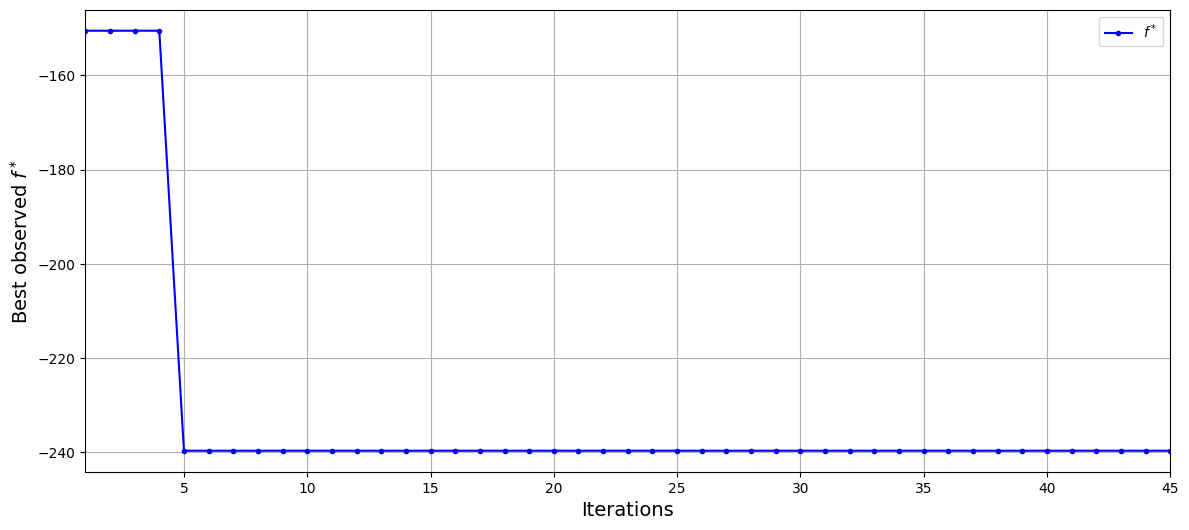

In [5]:
# Plotting variation of best value of objective function
fig, ax = plt.subplots(1, 1, figsize=(14,6))
ax.plot(np.arange(itr) + 1, ei_ybest, c="blue", label='$f^*$', marker=".")
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Best observed $f^*$", fontsize=14)
ax.legend()
ax.set_xlim(left=1, right=itr)
ax.grid()

# Sequential Sampling using Pricinpal Component Analysis (PCA) and EI

In [6]:
# Problem class
# Upper bound, lower bound and number of variables are added as parameters
class EI_DR(Problem):

    def __init__(self, sm, ymin, lb, ub, n_var, pca, center):
        super().__init__(n_var=n_var, n_obj=1, n_constr=0, xl=lb, xu=ub)

        self.sm = sm # store the surrogate model
        self.ymin = ymin
        self.pca = pca
        self.center = center
        
    def expected_improvement(self, x):
        
        numerator = self.ymin - self.sm.predict_values(x)
        denominator = np.sqrt( self.sm.predict_variances(x) )
        z = numerator / denominator
        
        return numerator * normal.cdf(z) + denominator * normal.pdf(z)
    
    def penalized_expected_improvement(self, x):
        
        # map back the candidate point to check if it falls inside the original domain
        x_ = self.pca.inverse_transform(x) + self.center
        idx_lower = np.where(x_ < -5.0)
        idx_lower = np.column_stack((idx_lower[0], idx_lower[1]))
        idx_upper = np.where(x_ > 5.0)
        idx_upper = np.column_stack((idx_upper[0], idx_upper[1]))
        
        out = self.expected_improvement(x)
        
        out[idx_lower] = -1000
        out[idx_upper] = -1000

        return out

    def _evaluate(self, x, out, *args, **kwargs):
        
        # Computing expected improvement
        # Negative sign because we want to maximize EI
        out["F"] = - self.penalized_expected_improvement(x) 

# Optimization algorithm
algorithm = DE(pop_size=100, CR=0.8, dither="vector")

In [7]:
random_state = 20
sampler = LHS(xlimits=xlimits, criterion='ese', random_state=random_state)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = f(xtrain)

# Variables
itr = 0
max_itr = 45
tol = 1e-3
max_EI = [1]
ybest = []
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
t1 = time.time()
while itr < max_itr:
    
    print("\nIteration {}".format(itr + 1))
    
    # Pre-processing data before applying PCA - standardization of data helps in PCA
    center = xtrain.mean(axis = 0)
    xtrain_center = xtrain - center 

    # Applying PCA to the data
    transform = PCA(n_components=5)
    xprime = transform.fit_transform(xtrain_center)

    # Defining the bounds
    lb = xprime.min(axis = 0)
    ub = xprime.max(axis = 0)

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xprime, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the best observed sample
    ybest.append(np.min(ytrain))

    # Find the minimum of surrogate model
    result = minimize(EI_DR(sm, ybest[-1], lb=lb, ub=ub, n_var = xprime.shape[1], pca = transform, center = center), 
                      algorithm, verbose=False)
    
    # Inverse transform to the real space
    inverse_X = transform.inverse_transform(result.X.reshape(1,-1)) + center
    
    # Computing true function value at infill point
    y_infill = f(inverse_X)

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[np.argmin(ytrain)].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[np.argmin(ytrain)]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, inverse_X ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

t2 = time.time()
# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))

# Storing results
pca_xbest = xbest
pca_ybest = ybest
pca_time = t2 - t1


Iteration 1
Maximum EI: 9.782232412635054
Best observed value: -150.53602901269912

Iteration 2
Maximum EI: 7.865841529174926
Best observed value: -150.53602901269912

Iteration 3
Maximum EI: 17.528029919565974
Best observed value: -150.53602901269912

Iteration 4
Maximum EI: 8.3098345342346
Best observed value: -150.53602901269912

Iteration 5
Maximum EI: 13.276081250413768
Best observed value: -150.53602901269912

Iteration 6
Maximum EI: 17.8023133448591
Best observed value: -150.53602901269912

Iteration 7
Maximum EI: 15.384107967256963
Best observed value: -150.53602901269912

Iteration 8
Maximum EI: 55.00862858226949
Best observed value: -150.53602901269912

Iteration 9
Maximum EI: 10.257994586097272
Best observed value: -150.53602901269912

Iteration 10
Maximum EI: 20.83528651097844
Best observed value: -150.53602901269912

Iteration 11
Maximum EI: 17.455296429242672
Best observed value: -150.53602901269912

Iteration 12
Maximum EI: 8.534624039246456
Best observed value: -179.37

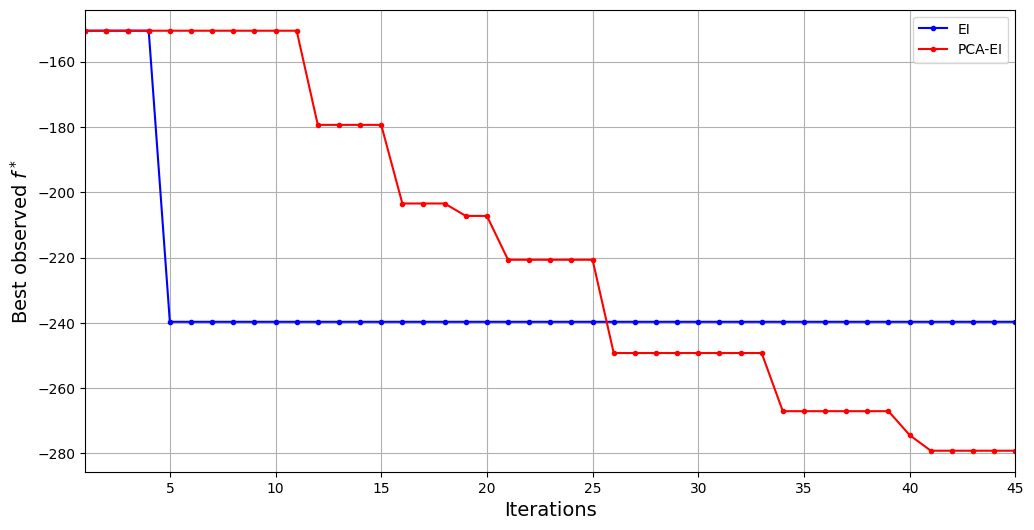

In [8]:
# Plotting and comparing variation of best value of objective function
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(np.arange(itr) + 1, ei_ybest, c="blue", label='EI', marker=".")
ax.plot(np.arange(itr) + 1, ybest, c="red", label='PCA-EI', marker=".")
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Best observed $f^*$", fontsize=14)
ax.legend()
ax.set_xlim(left=1, right=itr)
ax.grid()

# Sequential Sampling using Kernel PCA and EI

In [12]:
random_state = 20
sampler = LHS(xlimits=xlimits, criterion='ese', random_state=random_state)

# Training data
num_train = 20
xtrain = sampler(num_train)
ytrain = f(xtrain)

# Variables
itr = 0
max_itr = 45
tol = 1e-3
max_EI = [1]
ybest = []
corr = 'squar_exp'
fs = 12

# Sequential sampling Loop
t1 = time.time()
while itr < max_itr:
    
    print("\nIteration {}".format(itr + 1))
    
    # Pre-processing data before applying PCA - standardization of data helps in PCA
    center = xtrain.mean(axis = 0)
    xtrain_center = xtrain - center 

    # Applying PCA to the data
    transform = KernelPCA(n_components=5, kernel='cosine', fit_inverse_transform=True)
    xprime = transform.fit_transform(xtrain_center)
    
    # Defining the bounds
    lb = xprime.min(axis = 0)
    ub = xprime.max(axis = 0)

    # Initializing the kriging model
    sm = KRG(theta0=[1e-2], corr=corr, theta_bounds=[1e-6, 1e2], print_global=False)

    # Setting the training values
    sm.set_training_values(xprime, ytrain)
    
    # Creating surrogate model
    sm.train()

    # Find the best observed sample
    ybest.append(np.min(ytrain))

    # Find the minimum of surrogate model
    result = minimize(EI_DR(sm, ybest[-1], lb=lb, ub=ub, n_var = xprime.shape[1], pca = transform, center = center), 
                      algorithm, verbose=False)
    
    # Inverse transform to the real space
    inverse_X = transform.inverse_transform(result.X.reshape(1,-1)) + center
    
    # Computing true function value at infill point
    y_infill = f(inverse_X)

    # Storing variables
    if itr == 0:
        max_EI[0] = -result.F[0]
        xbest = xtrain[np.argmin(ytrain)].reshape(1,-1)
    else:
        max_EI.append(-result.F[0])
        xbest = np.vstack((xbest, xtrain[np.argmin(ytrain)]))

    print("Maximum EI: {}".format(max_EI[-1]))
    print("Best observed value: {}".format(ybest[-1]))
    
    # Appending the the new point to the current data set
    xtrain = np.vstack(( xtrain, inverse_X ))
    ytrain = np.append( ytrain, y_infill )
    
    itr = itr + 1 # Increasing the iteration number

t2 = time.time()
# Printing the final results
print("\nBest obtained point:")
print("x*: {}".format(xbest[-1]))
print("f*: {}".format(ybest[-1]))

# Storing time cost results
kpca_time = t2 - t1


Iteration 1
Maximum EI: 6.309217063641253
Best observed value: -150.53602901269912

Iteration 2
Maximum EI: 41.55228510287358
Best observed value: -150.53602901269912

Iteration 3
Maximum EI: 18.270344826810362
Best observed value: -182.85174969357095

Iteration 4
Maximum EI: 8.973085565396698
Best observed value: -182.85174969357095

Iteration 5
Maximum EI: 10.512232848091156
Best observed value: -190.13978538721625

Iteration 6
Maximum EI: 18.151449276261083
Best observed value: -190.13978538721625

Iteration 7
Maximum EI: 12.930257329509384
Best observed value: -190.13978538721625

Iteration 8
Maximum EI: 8.787769823142817
Best observed value: -194.5357406227563

Iteration 9
Maximum EI: 11.860761103156227
Best observed value: -194.5357406227563

Iteration 10
Maximum EI: 9.200722728625319
Best observed value: -199.44148163034978

Iteration 11
Maximum EI: 8.984318121964524
Best observed value: -199.44148163034978

Iteration 12
Maximum EI: 13.006156116132438
Best observed value: -199.

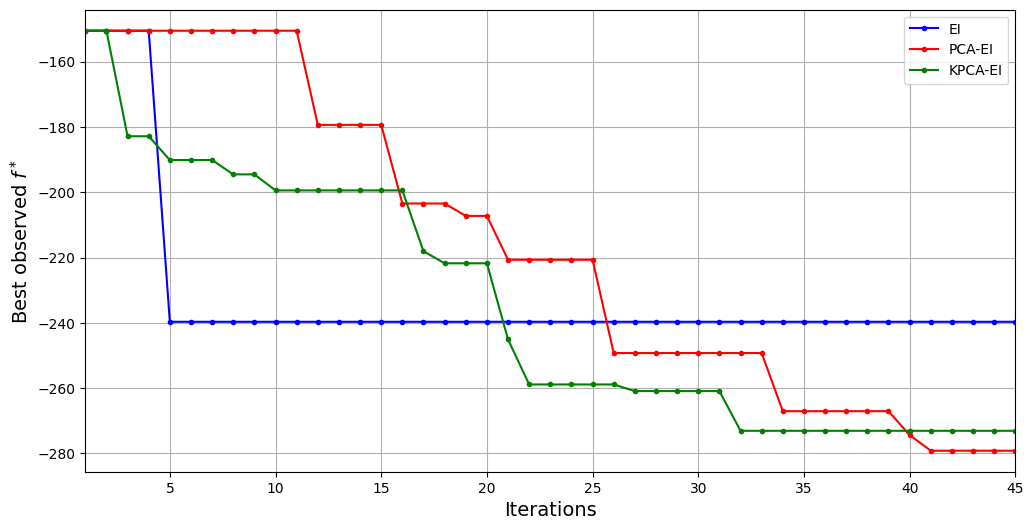

In [13]:
# Plotting and comparing variation of best value of objective function
fig, ax = plt.subplots(1, 1, figsize=(12,6))
ax.plot(np.arange(itr) + 1, ei_ybest, c="blue", label='EI', marker=".")
ax.plot(np.arange(itr) + 1, pca_ybest, c="red", label='PCA-EI', marker=".")
ax.plot(np.arange(itr) + 1, ybest, c="green", label='KPCA-EI', marker=".")
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Best observed $f^*$", fontsize=14)
ax.legend()
ax.set_xlim(left=1, right=itr)
ax.grid()

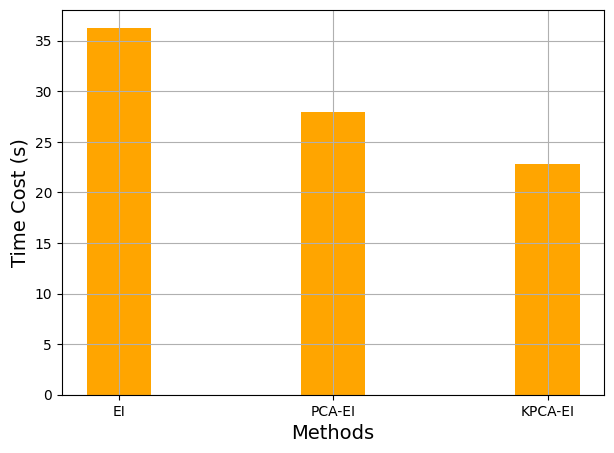

In [14]:
fig, ax = plt.subplots(figsize=(7,5))
methods = ['EI', 'PCA-EI', 'KPCA-EI']
times = [ei_time, pca_time, kpca_time]
ax.bar(methods, times, color ='orange', width = 0.3)
ax.set_xlabel("Methods", fontsize = 14)
ax.set_ylabel("Time Cost (s)", fontsize = 14)
ax.grid()